In [1]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import IPython
from scipy import signal
from scipy import fft

freqFormatter = matplotlib.ticker.EngFormatter(unit='Hz')

# Objective

In this notebook, we demonstrate how to take a set of raw IQ samples captured from an RTL-SDR dongle tuned to a FM broadcast radio station at 101.3 MHz and play the station's audio. We will leverage filtering, decimation, demodulation, and resampling to process the data. We will also demonstrate how we can digitally re-center our signal to tune to another station using the same data.

# First Things First: Capture and Import the IQ Data

First, we need some data to work with. Python libraries for acquiring data from the RTL-SDR exist, but we'll keep things a bit simpler and use the [command-line utility](https://osmocom.org/projects/rtl-sdr/wiki#rtl-sdr-2) to capture samples. A typical command line looks something like this:

```
rtl_sdr -f 101300000 -s 2048000 -g 32 -n 20480000 samples.bin
```

Breaking this down:

- Tuning to center frequency 101.3 MHz
- Sampling at 2048 kHz
- Setting hardware gain to 32dB
- Collect 20.48M samples (10 seconds worth)
- Save the data to the file `samples.bin`

The file format is simply alternating 8-bit I and Q values captured from the ADC. It is trivial to import the sample data into a NumPy array in Python:

In [2]:
samples_uint8 = np.fromfile('samples.bin', dtype=np.uint8)

As an aside, the sampling rate of 2048 kHz is more than we strictly need to capture a single channel, but we'll see how we can use this extra information to tune to listen to other stations without needing to retune to a new center frequency and re-capture samples.

## Confirm Appropriate Gain in the Capture

We want to make sure that the gain used for capturing isn't so high that the signal is getting clipped, but high enough that we're maximizing the ADC's dynamic range. A histogram of all of the sample values will readily show us this information.

For real-world applications where the transmitter and/or receiver are moving, or the path traveled by the radio signals is otherwise changing, we would need to get fancier and implement an [automatic gain control (AGC)](https://en.wikipedia.org/wiki/Automatic_gain_control) algorithm that adjusts the gain over time to compensate for changing signal strength. In this notebook, though, we're keeping it simple and capturing with a fixed gain.

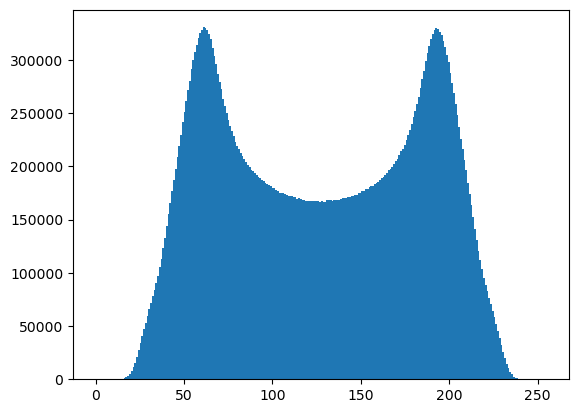

In [3]:
# Create a histogram with 256 bins evenly spaced between 0 and 255, inclusive
fix, ax = plt.subplots()
ax.hist(samples_uint8, bins=256, range=(0,255))
plt.show()

This looks great! We're utilizing most of the 8-bit range from 0 to 255, and don't see any spikes at 0 or 255 that would be indicative of clipping.

### Convert IQ Pairs into Complex Values

In signal processing, we typically store the in-phase and quadrature components as the real and imaginary parts of a complex value. This allows us to treat each IQ sample as a single complex value in an array, and allows us to conveniently interface with APIs which can natively handle complex values.

In [4]:
# Turn them into signed int8s with and reshape into I and Q
samples = (samples_uint8 - 128).astype(dtype=np.int8).reshape((-1, 2))

# Now make it a single-dimension of complex values
samples_complex = samples[:, 0] + 1j * samples[:, 1]

### Preview the Signal Spectrum

Let's get a feel for the signal we're working with by taking a look at the spectrum. The quadrature mixing performed in the SDR allowed us to translate our 101.3 MHz signal to baseband, with a span from -1024 to 1024 kHz ($-f_s/2$ to $f_s/2$).

Here, we can see a strong spike at 0 Hz, corresponding to the FM station at 101.3 MHz that we tuned to. We also see some smaller humps at -800 kHz, corresponding to the radio station at 100.5 MHz, and at 800 kHz, corresponding to the radio station at 102.1 MHz.

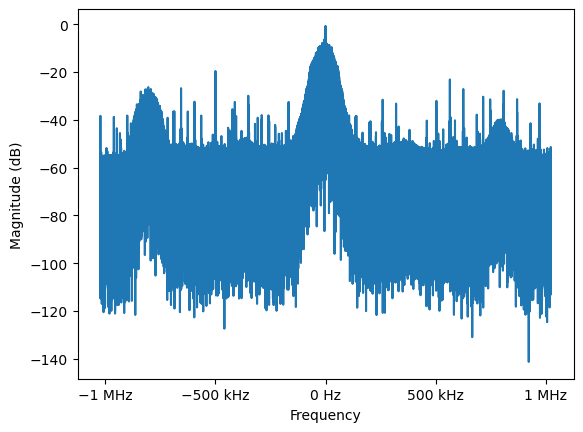

In [5]:
fs = 2048e3 # Sample rate is 2048 kHz

fig, ax = plt.subplots()
ax.magnitude_spectrum(samples_complex, Fs=fs, scale='dB')
ax.xaxis.set_major_formatter(freqFormatter)
plt.show()

# Demodulate the FM Station

As shown above, our capture includes not just the station of interest, 101.3 MHz, but also other stations and noisy unused spectrum between the stations. Our first step, then, is to filter the signal so that it contains only the station that we're interested in.

## Filter to Desired Station

In the U.S., the FM broadcasting band is divided into channels with 200 kHz spacing, with each channel being centered at an odd-numbered 100 kHz frequency. To isolate our signal that is already centered at baseband, then, we want to create a low-pass filter (LPF) that spans from -100 kHz to 100 kHz.

### Design an FIR Low Pass Filter

One of the simplest ways to design a filter design methods is the [windowed-sinc filter approach](https://www.dspguide.com/ch16.htm). Several examples of this technique can be found in my [AudioFilteringDemo notebook](https://github.com/fjenner/AudioFilteringDemo/blob/master/FIRDemo.ipynb). Here, though, we'll simply leverage SciPy's `firwin()` function to generate the filter taps for us.

In [6]:
filter_taps_200khz = signal.firwin(numtaps=255, cutoff=100e3, fs=fs)

### Observe the Frequency Response of the Filter

We can confirm that the filter performs as expected by looking at its frequency response. We can, get that by taking the DFT of the filter taps, which we'll do here through the `magnitude_spectrum()` plotting function. We'll also add some zero padding to increase the frequency resolution and zoom in better on the transition region.

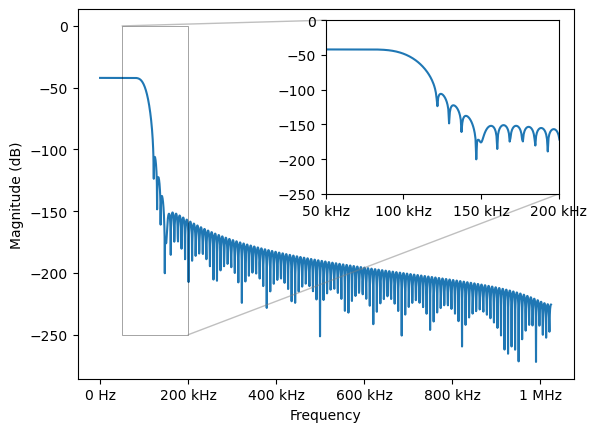

In [7]:
fig, ax = plt.subplots()

# Plot the full frequency response
ax.magnitude_spectrum(filter_taps_200khz, pad_to=4096, Fs=fs, scale='dB')
ax.xaxis.set_major_formatter(freqFormatter)

# Plot a zoomed-in view
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(50e3, 200e3),
    ylim=(-250, 0))
axins.magnitude_spectrum(filter_taps_200khz, pad_to=4096, Fs=fs, scale='dB')
axins.xaxis.set_major_formatter(freqFormatter)
axins.set_xlabel(None)
axins.set_ylabel(None)
ax.indicate_inset_zoom(axins, ec='black', lw=0.5, alpha=0.5)

plt.show()

This filter gives roughly 60dB of attenuation in the stopband, and the rolloff only extends out about 20 kHz from the cutoff to the stopband. For our FM broadcast station, which has no immediately adjacent channels, these filter parameters should be more than adequate.

Note that we could have selected different windows to select a different tradeoff between rolloff and stopband attenuation for a given number of taps. We could have also used more taps to get a sharper cutoff, or cascaded multiple filters to achieve better stopband attenuation.

### Filter the Original Samples

Now that our filter is designed, we can filter our original signal and see what it looks like.

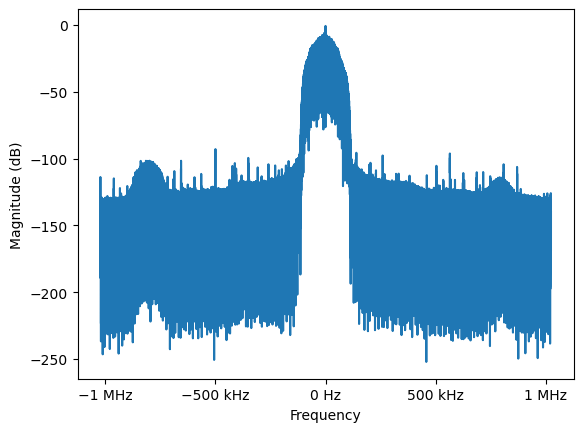

In [8]:
# Perform the filtering
samples_filtered = np.convolve(samples_complex, filter_taps_200khz)

# Plot the spectrum
fig, ax = plt.subplots()
ax.magnitude_spectrum(samples_filtered, Fs=fs, scale='dB')
ax.xaxis.set_major_formatter(freqFormatter)
plt.show()

This looks great! The other stations are nearly 100 dB (an amplitude of 1/10000) lower than the the center of the station we're interested in.

## Downsample to a Lower Sample Rate

The original capture was sampled at 2048 kHz, which is overkill for processing a signal with a 200 kHz bandwidth. To ease processing requirements, we can downsample our signal without losing any information as long as the new sampling rate is still 2x our bandwidth, per Nyquist. Downsampling by an integer factor of $M$ simply involves retaining every $M$th sample. The process of low-pass filtering a signal for anti-aliasing followed by downsampling is called **decimation**.

Because our signal bandwidth is now limited to 200 kHz, we can safely decimate to any rate of at least 400 kHz. A decimation by 5 should do the trick, and will yield a new sample rate of $2048 \text{kHz} / 5 = 409.6 \text{kHz}$.

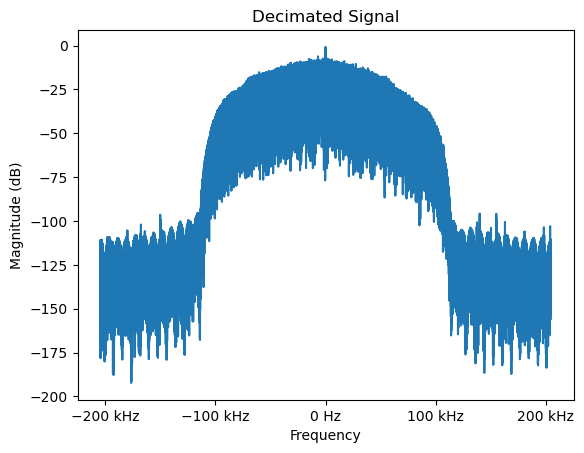

In [9]:
# Take every fifth sample
DECIMATION_FACTOR = 5
fs_decimated = fs / DECIMATION_FACTOR
samples_decimated = samples_filtered[::DECIMATION_FACTOR]

# Plot the decimated signal's spectrum
fig, ax = plt.subplots()
ax.magnitude_spectrum(samples_decimated, Fs=fs_decimated, scale='dB')
ax.xaxis.set_major_formatter(freqFormatter)
ax.set_title('Decimated Signal')
plt.show()

## Demodulate the FM Signal

As the name FM - frequency modulation - implies, the message information is contained in the instantaneous frequency of the signal. Recall that the frequency is simply the rate of change, or derivative, of the phase. To determine the phase of our quadrature signal, we need to take the $\text{atan2}(Q, I)$. For samples that are already represented as complex values, we can get the equivalent functionality by using NumPy's `angle()` function:

In [10]:
phases = np.angle(samples_decimated)

The `angle()` function, like the $\text{atan2}()$ function, returns an angle between $-\pi$ and $\pi$ radians. This means that our phase sequence will have discontinuities when the phase increases beyond $\pi$ radians or decreases beyond $\pi$ radians. We can see this by observing an arbitrary subset of the phase sequence:

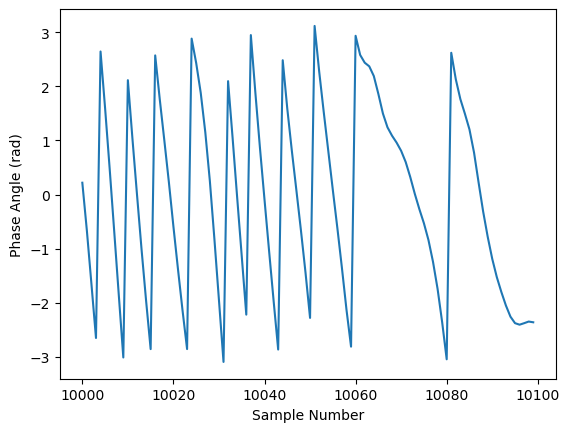

In [11]:
subset = np.arange(10000, 10100)
fig, ax = plt.subplots()
ax.plot(subset, phases[subset])
ax.set_xlabel('Sample Number')
ax.set_ylabel('Phase Angle (rad)')
plt.show()

It is not possible to calculate the frequencies with these discontinuities. Fortunately, we can easily detect where these discontinuities occur (indicated by a jump of more than $\pi$ radians between successive samples) and adding or subtracting a $2\pi$ offset to subsequent samples to arrive at the unwrapped phase. Conveniently, NumPy has a function for this: `unwrap()`.

In [12]:
unwrapped_phases = np.unwrap(phases)

Replotting with the same set of samples, we now see how the phase changes without "wrapping" between $-\pi$ and $\pi$.

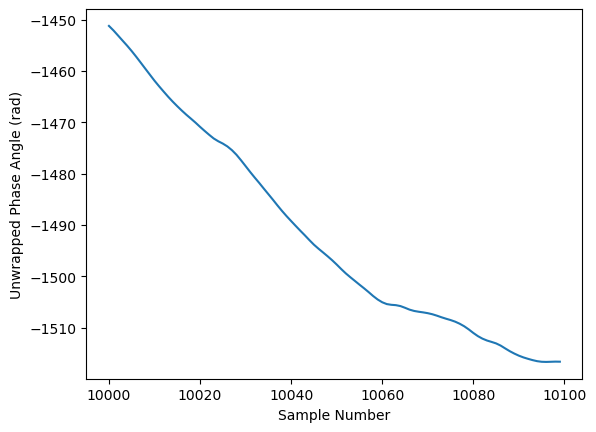

In [13]:
fig, ax = plt.subplots()
ax.plot(subset, unwrapped_phases[subset])
ax.set_xlabel('Sample Number')
ax.set_ylabel('Unwrapped Phase Angle (rad)')
plt.show()

Now that we have the phase information, we can calculate the frequency as the derivative of phase. In discrete time, the equivalent of the first derivative is called the "first difference", and is simply the difference between successive samples. Although trivial to compute, NumPy once again makes this even more convenient for us with its `diff()` function.

In [14]:
frequencies = np.diff(unwrapped_phases)

That's it - we're demodulated! As mentioned, the message signal is conveyed in the frequency, so we've recovered our message signal. (Technically, the frequencies are a *scaled* version of the message signal, but that scaling isn't important for now.)

In [15]:
message = frequencies

Even though we've demodulated the message, there are two issues that prevent us from playing the audio at this point:

1. The message signal for FM broadcast stations itself contains several subcarriers that include, but are not limited to, the audio signal we're interested in
2. In order to play audio, we must perform sample rate conversion to downsample our 409.6 kHz samples down to a common audio sample rate supported by the computer's audio hardware

# Extract Audio from the Subcarriers

In the early days of FM radio, the "message" signal contained only a monophonic audio signal in the audio frequency range of the message signal. Modern radio stations, however, encode additional information into the ultrasonic frequency range of the message signal. This typically includes "subcarriers" containing stereo audio signals, Radio Data Service (RDS) data, and potentially additional services. The figure below (taken from [this Wikipedia article](https://en.wikipedia.org/wiki/FM_broadcasting)) shows the subcarriers used for multiplexing additional information into some FM broadcast signals.

![FM Subcarriers](images/fm_subcarriers.svg)

These additional subcarriers pose no threat to legacy analog radio receivers because they would be outside of the audible frequency range, so the radio could simply send the demodulated signal to the speaker and only the monophonic audio signal would actually be audible. However, with digital signals, if we want to convert this signal to an audio sampling rate for playback, these higher-frequency subcarriers would alias, fold over into the audible frequency range, and interfere with our audio signal. We must therefore filter these out.

Here is the frequency spectrum of our current message signal:

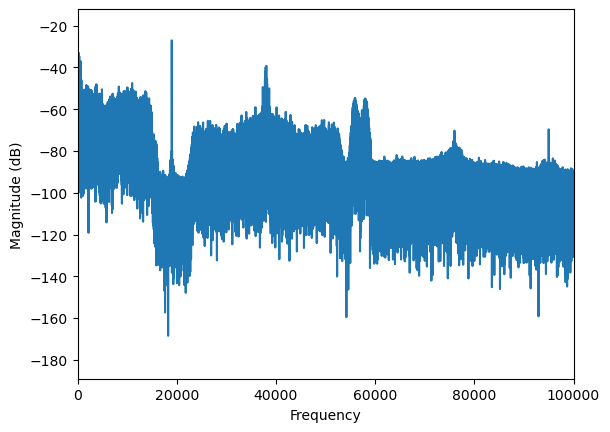

In [16]:
fig, ax = plt.subplots()
ax.magnitude_spectrum(message, Fs=fs_decimated, scale='dB')
ax.set_xlim(0, 100e3)
plt.show()

It doesn't look as nice as the Wikipedia drawing, but we can definitely see several of the features:
- We see a band up through 15 kHz corresponding to the L+R audio signal
- We see a spike at 19 kHz corresponding to the pilot tone
- We see a symmetric band from 23 kHz to 38 kHz corresponding to the stereo information
- We see a symmatric band around 57 kHz corresponding to the RDS data

## Isolate the Mono Audio Subcarrier

For now, let's focus on extracting the audio from the mono audio band from 30 Hz to 15kHz. By design, this band is already in the correct audio frequency range. We merely need to filter out the other signals outside of this band to avoid aliasing. We can accomplish this with another filter. Because the signal starts at 30 Hz rather than 0 Hz, we should use a bandpass filter rather than a low pass filter.

Bandpass filter design begins with low pass filter design. We design a low pass filter that has the desired bandwidth, and then multiply the impulse response by a sinusoid to shift it (remember, mixing with a sinusoid in the time domain corresponds to shifting the signal in the frequecy domain). We want a filter bandwidth of $15000-30=14970$ Hz. To create a low pass filter with that bandwidth, we specify a cutoff of half that value, $14970/2=7495$ Hz, as the passband extends symmetrically in both the positive and negative frequencies:

In [17]:
filter_taps_lpf_14970hz = signal.firwin(numtaps=4095, cutoff=7495, fs=fs_decimated)

We now have a low pass filter, but we want a bandpass filter centered in the middle of the mono audio subcarrier band, at $(30 + 15000)/2=7515$ Hz. We can do so by multiplying our filter coefficients by a sinusoid of 7515 Hz:

In [18]:
shift_sequence = np.cos(2 * np.pi * (7515 / fs_decimated) * np.arange(0, filter_taps_lpf_14970hz.size))
filter_taps_bpf_7515hz = filter_taps_lpf_14970hz * shift_sequence

Inspecting the frequency response of the original LPF coefficients versus our BPF coefficients, we see that we have successfully created a filter that extends from 30 Hz to 15 kHz.

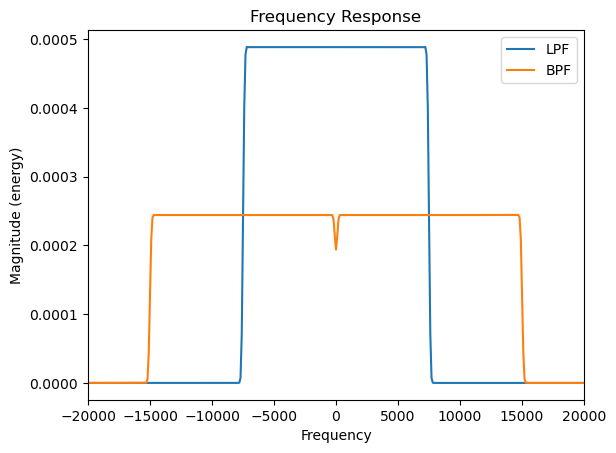

In [19]:
fig, ax = plt.subplots()
ax.magnitude_spectrum(filter_taps_lpf_14970hz, Fs=fs_decimated, sides='twosided', label='LPF')
ax.magnitude_spectrum(filter_taps_bpf_7515hz, Fs=fs_decimated, sides='twosided', label='BPF')
ax.set_xlim((-20000, 20000))
ax.legend()
ax.set_title('Frequency Response')

plt.show()

Now that we've got our bandpass filter, lets convolve our message signal with it to filter the mono audio:

In [20]:
message_filtered_mono = np.convolve(message, filter_taps_bpf_7515hz)

The figure below shows our signal spectrum before and after filtering:

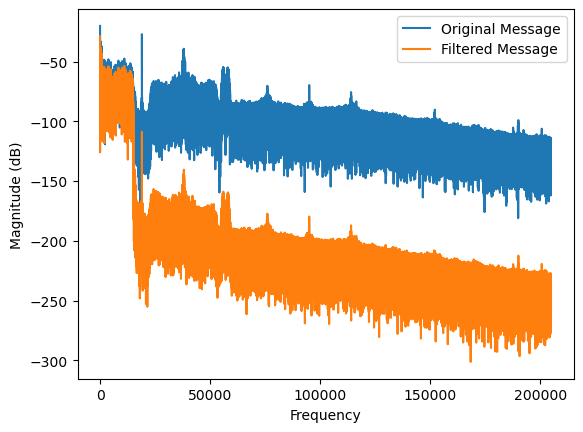

In [21]:
fig, ax = plt.subplots()

ax.magnitude_spectrum(message, Fs=fs_decimated, scale='dB', label='Original Message')
ax.magnitude_spectrum(message_filtered_mono, Fs=fs_decimated, scale='dB', label='Filtered Message')
ax.legend()

plt.show()

## Convert to a Common Sample Rate

Audio codec hardware and software audio frameworks typically cannot work with arbitrary sample rates. Instead, they support only a set of common sample rates used for audio applications. For example, a common sample rate for audio is 44.1 kHz, which provides a sufficient rate to sample the entire sound spectrum that is audible to humans (generally considered to be from 20 Hz to 20 kHz), plus some additional headroom for rolloff. This is also the sample rate that CDs use (remember those?). We'll pick this sample rate because it is widely supported and is sufficient to represent our band-limited audio signal from 30 Hz to 15 kHz.

There are many techniques, and many more implementation variants, to perform sample rate conversion. Here, we want to downconvert our signal from 409.6 kHz down to 44.1 kHz. One approach is to take the DFT of the signal and, in the frequency domain, either zero-pad the signal to increase the number of samples (for upsampling) or truncate the signal to decrease the number of samples (for downsampling), and then take the inverse DFT to get a resampled version of the signal in the time domain. This technique is implemented by SciPy's `resample()` function, which we'll use here for simplicity.

In [22]:
PLAYBACK_RATE=44100
mono_audio = signal.resample(message_filtered_mono, PLAYBACK_RATE * int(message_filtered_mono.size / fs_decimated))

At this point, we can finally play our audio signal!

In [23]:
IPython.display.Audio(mono_audio, rate=PLAYBACK_RATE)

## De-emphasis

The signal above sounds okay, but it's a bit "tinny". There seems to be a lot of high-end treble to it. This is because, at the transmitter, the high frequencies have been boosted, with the expectation that the receiver will perform the inverse operation. This boosting at the transmitter and attenuating at the receiver are called **pre-emphasis** and **de-emphasis**, repsectively.

FM stations do this because the differentiation step performed during demodulation inherently amplifies high-frequency noise - if you pass a pure noise signal through a derivative, the resulting spectrum will show that the energy is concentrated at high frequencies. To offset the effect of this noise, FM broadcasters use a high-pass pre-emphasis filter on the audio to boost the high end. To get the intended audio characteristic back, we must apply a corresponding de-emphasis filter.

### Create De-emphasis Filter

The specific pre-emphasis and de-emphasis filters used by broadcast FM are described well in detail in the comments of GNU Radio's implementation here: https://github.com/gnuradio/gnuradio/blob/v3.10.8.0/gr-analog/python/analog/fm_emph.py#L16.

The original specification for FM broadcasting expressed the pre-/de-emphasis filters in terms of analog RC filter circuits, and GNU Radio have employed a technique to translate that into a digital infinite impulse response (IIR) filter. The specifics are out of the scope of this demonstration.

In [24]:
fs_audio = PLAYBACK_RATE
tau = 75e-6

w_c = 1.0 / tau

# Prewarped analog corner frequency
w_ca = 2.0 * fs * math.tan(w_c / (2.0 * fs_audio))

# Resulting digital pole, zero, and gain term from the bilinear
# transformation of H(s) = w_ca / (s + w_ca) to
# H(z) = b0 (1 - z1 z^-1)/(1 - p1 z^-1)
k = -w_ca / (2.0 * fs)
z1 = -1.0
p1 = (1.0 + k) / (1.0 - k)
b0 = -k / (1.0 - k)

deemph_btaps = [b0 * 1.0, b0 * -z1]
deemph_ataps = [1.0, -p1]

The impulse response of an IIR filter, as the name suggests, is infinite in length. We therefore cannot represent the impulse response directly in order to take its DFT and view the frequency response, nor to convolve it directly with our input signal. We must use a different approach for these operations. For now, the details are out of the scope of this demonstration, but the SciPy `freqz()` function will provide us with the frequency response of the filter, which is plotted below.

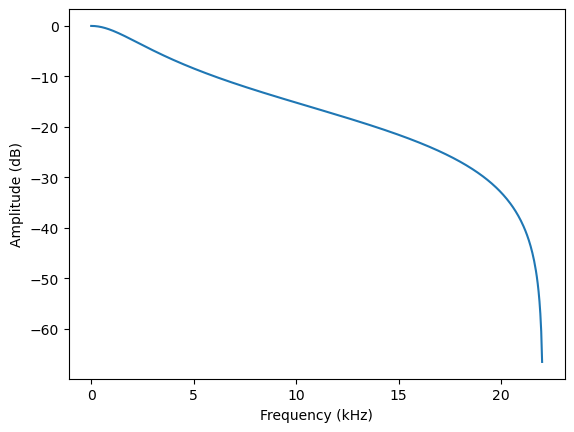

In [25]:
# Plot the frequency response
w, h = signal.freqz(deemph_btaps, deemph_ataps, fs=fs_audio)
fig, ax = plt.subplots()
plt.plot(w / 1000, 20 * np.log10(abs(h)))
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Amplitude (dB)')
plt.show()

### Apply De-emphasis Filter

Again, because of the infinite nature of the IIR, we cannot simply leverage convolution directly to filter our signal. Instead, we'll rely on the SciPy `lfilter()` function to handle this.

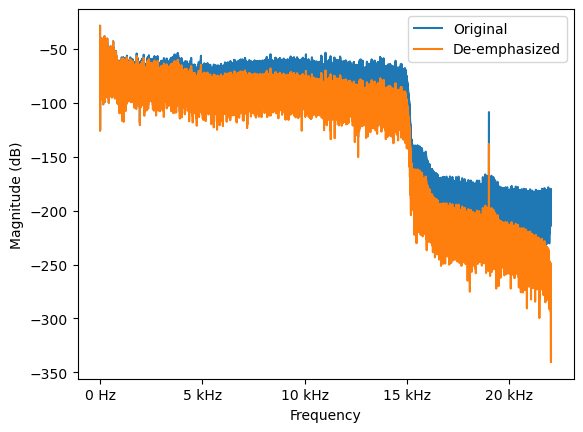

In [26]:
# Filter our signal
mono_audio_deemphasized = signal.lfilter(deemph_btaps, deemph_ataps, mono_audio)

# Examine the effect
fig, ax = plt.subplots()
ax.magnitude_spectrum(mono_audio, Fs=PLAYBACK_RATE, scale='dB', label="Original")
ax.magnitude_spectrum(mono_audio_deemphasized, Fs=PLAYBACK_RATE, scale='dB', label="De-emphasized")
ax.xaxis.set_major_formatter(freqFormatter)
ax.legend()
plt.show()

### Hear the Difference

In [27]:
# Play the audio
audio1 = IPython.display.Audio(mono_audio, rate=PLAYBACK_RATE)
audio2 = IPython.display.Audio(mono_audio_deemphasized, rate=PLAYBACK_RATE)

print("No de-emphasis")
IPython.display.display(audio1)
print("With de-emphasis")
IPython.display.display(audio2)

No de-emphasis


With de-emphasis


# Try Another Channel

Recall that we originally captured our IQ data at 2048 MHz centered around 101.3 MHz. This means we captured additional local FM stations, too. Specfically, we've caught stations as 100.5 MHz and 102.1 MHz. We can therefore tune to one of these other stations and demodulate it in software without having to collect any new data! Let's see this in action with 100.5 MHz.

## Mixing up to Baseband

We originally centered our capture at 101.3 MHz, meaning that the station at 100.5 MHz is -800 kHz away from baseband (0 Hz). We can bring this signal up to baseband by mixing with a complex sinuoid having a frequency of 800 kHz.

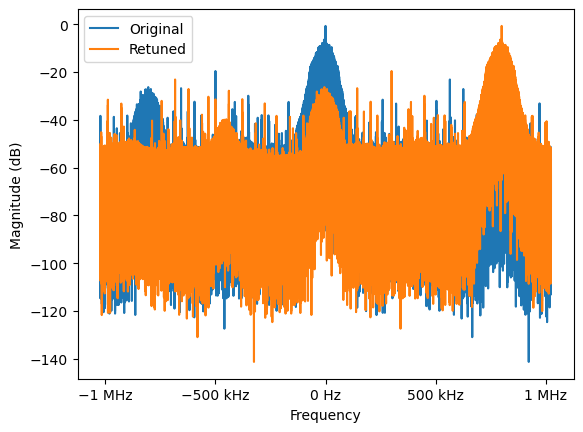

In [28]:
# Multiply the original data by an 800kHz local oscillator
# to mix the station up to baseband
original = samples_complex
t = np.arange(0, original.size / fs, 1 / fs)
lo = np.exp(1j * 2 * math.pi * 800e3 * t)
retuned = np.multiply(original, lo)

# Plot the original spectrum vs. the new spectrum
fig, ax = plt.subplots()
ax.magnitude_spectrum(original, Fs=fs, scale='dB', label='Original')
ax.magnitude_spectrum(retuned, Fs=fs, scale='dB', label='Retuned')
ax.xaxis.set_major_formatter(freqFormatter)
ax.legend()
plt.show()

## Do it All Again!

From here, we'll take the exact same steps that we did with the original signal. We'll just do it all in one go this time. Summarizing what we've already done, and what we'll be doing again:

* Use a low-pass filter to filter out everything around the 200 kHz FM channel centered at baseband
* Decimate down to a 409.6 kHz sampling rate to ease computation
* Demodulate the FM signal by taking the first-difference (discrete derivative) of the phase to arrive at instantaneous frequencies
* Low-pass filter the demodulated signal to isolate the L+R audio
* Resample to a common audio sampling rate for playback
* Apply the de-emphasis filter to knock down the treble that was pre-emphasized

In [29]:
# Filter to 200kHz around baseband
retuned_filtered = np.convolve(retuned, filter_taps_200khz)

# Decimate by a factor of 5
retuned_decimated = retuned_filtered[::DECIMATION_FACTOR]

# Calculate the instantaneous frequencies from the phase angles
phases = np.unwrap(np.angle(retuned_decimated))
retuned_demodulated = np.diff(phases)

# Bandpass filter the L+R audio signal
retuned_audio = np.convolve(retuned_demodulated, filter_taps_bpf_7515hz)

# Resample to 44.1kHz audio rate
retuned_audio_resampled = signal.resample(retuned_audio, PLAYBACK_RATE * int(retuned_audio.size / fs_decimated))

# De-emphasize
retuned_audio_deemph = signal.lfilter(deemph_btaps, deemph_ataps, retuned_audio_resampled)

# Play the audio!
IPython.display.Audio(retuned_audio_deemph, rate=PLAYBACK_RATE)